In [22]:
print(np.linspace(0, 93, 4))

[ 0. 31. 62. 93.]


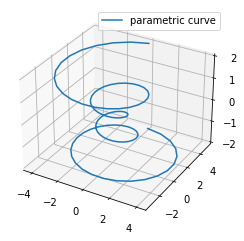

In [1]:
import numpy as np
import matplotlib.pyplot as plt


ax = plt.figure().add_subplot(projection='3d')

# Prepare arrays x, y, z
theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
z = np.linspace(-2, 2, 100)
r = z**2 + 1
x = r * np.sin(theta)
y = r * np.cos(theta)

ax.plot(x, y, z, label='parametric curve')
ax.legend()

plt.show()


In [ ]:
import numpy as np
from scipy.io import wavfile
from ssqueezepy import ssq_cwt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import sys

def scaler(array, min_, max_):
    '''
    array: input
    min_, max_: range of scaling
    '''
    array = array.reshape((-1, 1))
    scaler = MinMaxScaler(feature_range=(min_, max_))
    s_data = scaler.fit_transform(array)
    s_data = np.squeeze(s_data)
    return s_data

# Get wavelet from .wav file
def wav_to_wavelet(path):
    '''
    path: Direction to .wav file
    '''
    sample_rate, x = wavfile.read(path) 
    twx, wx, *_ = ssq_cwt(x)  # use wx
    print(f'shape: {wx.shape}')
    return np.abs(wx)

# Moving average function
def moving_average(array, window):
    '''
    array: short array have window length
    window: predefine value
    '''
    ret = np.cumsum(array, dtype=float)
    ret[window:] = ret[window:] - ret[:-window]
    return ret[window - 1:] / window

# Moving average for wavelet
def wavelet_to_moving_average(matrix, window):
    '''
    matrix: a set of short array
    window: predefine value
    '''
    ma = []
    for i in matrix:
        i = moving_average(i, window)
        i = np.expand_dims(i, axis=0)
        if ma == []:
            ma = i
        else:
            ma = np.concatenate((ma, i), axis=0)
    return ma


# def stairway(ma_row, bins, max_excursion):
#     '''
#     ma_row: a chosen row of MA
#     bins: number of bins
#     max_excursion: max chosen number for histogram

#     Note:
#     - Purpose: Get index according to each range 
#     - for example: '0 for range 0...249, 1 for 250...499, 2 for 500...749, 3 for 750... infinit
#     '''
#     range_ = np.linspace(0, max_excursion, bins).tolist()
#     min_ma = np.min(ma_row)
#     max_ma = np.max(ma_row)
    
#     if max_ma > range_[-1]:
#         range_[-1] = max_ma
#     pair_ = [range_[i:i+2] for i in range(bins-1)]

#     ma_hist = []
#     for va in ma_row:
#         for each_pair in pair_:
#             if each_pair[0] < va < each_pair[1]:
#                 ma_hist.append(pair_.index(each_pair)) 
    
#     # scaling histogram
#     ma_hist = np.array(ma_hist)
#     ma_hist = ma_hist.reshape(-1, 1)
#     scaler = MinMaxScaler(feature_range=(min_ma, max_ma))
#     ma_hist = scaler.fit_transform(ma_hist)
#     ma_hist = ma_hist.reshape(-1, )
#     return ma_hist   

def stairway(ma_row, bin_count, max_excursion):
    bins = np.linspace(0, max_excursion, bin_count)
    dig = (np.digitize(ma_row, bins) - 1) * (max_excursion / bin_count)
    return dig 

# Plot all visualizations
def plot_row(row, ax, c, matrix=None, option=None, hist=None, width=None):
    if np.max(matrix) != None:
        get = matrix[row]

    if np.max(hist) != None:
        ax.plot(hist, c=c)
    else:
        ax.plot(get, c=c)

if __name__ == '__main__':
    if len(sys.argv) != 3:
        print('Usage: python moving_average.py <path to wav file> <row number>')
        sys.exit(-1)

    wav_file = sys.argv[1]
    row = int(sys.argv[2])
    window = 1000
    max_excursion = 20
    bins = 10

    # computing part -------------------------------------------------------
    wavelet = wav_to_wavelet(wav_file)
    ma = wavelet_to_moving_average(wavelet, window)
    ma_hist = stairway(wavelet_to_moving_average(wavelet, window)[row], bins, max_excursion)

    # Plot part -------------------------------------------------------------
    fig = plt.figure()  
    ax = fig.add_subplot()
    plot_row(row, ax, 'bisque', matrix=wavelet)
    plot_row(row, ax, 'lightsteelblue', matrix=ma)
    plot_row(row, ax, 'g', hist=ma_hist, width=0.4)

    ax.set_title(f'Row {row} - Orange=source, Blue=averaged({window}), Green=histogram')
    plt.show()